In [1]:
import os
os.chdir('/home/fraza0/Desktop/MEI/TESE/nonverbal_communication_analysis')
print("Working Directory:", os.getcwd())
import ipywidgets as widgets

Working Directory: /home/fraza0/Desktop/MEI/TESE/nonverbal_communication_analysis


In [2]:
import pandas as pd
from pandas.io.json import json_normalize
import json
from pprint import pprint
import threading
from IPython.display import display
import ipywidgets as widgets
import time
import matplotlib.pyplot as plt
import numpy as np
from nonverbal_communication_analysis.environment import OPENFACE_OUTPUT_DIR, OPENPOSE_OUTPUT_DIR, VALID_OUTPUT_FILE_TYPES
from nonverbal_communication_analysis.utils import fetch_files_from_directory, filter_files

In [3]:
per_frame_metrics = {
    'n_people': 0,
    'valid_face_keypoints': 0,
    'total_valid_face_keypoints': 0,
    'valid_pose_keypoints': 0,
    'total_valid_pose_keypoints': 0,
}

vid_metrics = {}

In [4]:
groups_list = os.listdir(OPENPOSE_OUTPUT_DIR)

GROUP_ID = widgets.Dropdown(
    options=groups_list,
    value=groups_list[-1],
    description='Group:',
    disabled=False,
)
display(GROUP_ID)

Dropdown(description='Group:', index=4, options=('3CLC9VWR_output_OLD.tar.gz', '1403201803_output', 'walking_h…

In [5]:
_dir = OPENPOSE_OUTPUT_DIR+GROUP_ID.value+"/output_pc1/"
input_files = [_dir+file for file in filter_files(fetch_files_from_directory([_dir]), valid_types = VALID_OUTPUT_FILE_TYPES)]
input_files.sort()
total_files = len(input_files)
print("Found: %s files" % total_files)

Found: 72178 files


In [6]:
CONFIDENCE_THRESHOLD = widgets.FloatSlider(
    value=0.55,
    min=0,
    max=1.0,
    step=0.05,
    description='Minimum Keypoint Confidence:',
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)
display(CONFIDENCE_THRESHOLD)

FloatSlider(value=0.55, description='Minimum Keypoint Confidence:', max=1.0, readout_format='.1f', step=0.05)

In [7]:
def calculate_person_valid_keypoints(person_df):
    valid_person_pose_keypoints = 0
    person_entry = [person_df[x:x+3] for x in range(0, len(person_df), 3)]
    for pose_entry in person_entry:
        confidence = pose_entry[2]
        if confidence > CONFIDENCE_THRESHOLD.value:
            valid_person_pose_keypoints += 1
    return valid_person_pose_keypoints

In [9]:
%%time

counter = 0
for file in input_files:
    per_frame_metrics = {}
    with open(file) as json_data:
        data = json.load(json_data)
        df = json_normalize(data['people'])
        per_frame_metrics['n_people'] = len(df['person_id'])
        per_frame_metrics['valid_face_keypoints'] = dict(df['face_keypoints_2d'].apply(calculate_person_valid_keypoints))
        per_frame_metrics['total_valid_face_keypoints'] = sum(per_frame_metrics['valid_face_keypoints'].values())
        per_frame_metrics['valid_pose_keypoints'] = dict(df['pose_keypoints_2d'].apply(calculate_person_valid_keypoints))
        per_frame_metrics['total_valid_pose_keypoints'] = sum(per_frame_metrics['valid_pose_keypoints'].values())
#         per_frame_metrics['pose_keypoints'] = df[]
        vid_metrics[counter] = per_frame_metrics
        json_data.close()
    counter += 1

CPU times: user 4min 13s, sys: 2.95 s, total: 4min 16s
Wall time: 7min 54s


## Simple Analysis of data consistency

In [10]:
num_people_time = [vid_metrics[frame_metrics]['n_people'] for frame_metrics in vid_metrics]
pose_keypoints_time = [vid_metrics[frame_metrics]['total_valid_pose_keypoints'] for frame_metrics in vid_metrics]
face_keypoints_time = [vid_metrics[frame_metrics]['total_valid_face_keypoints'] for frame_metrics in vid_metrics]

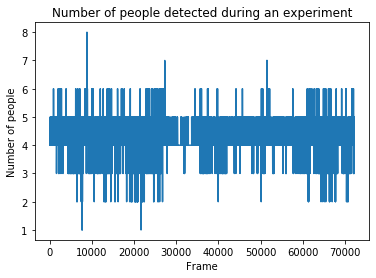

In [11]:
plt.plot(range(total_files), num_people_time)
plt.xlabel("Frame")
plt.ylabel("Number of people")
plt.title("Number of people detected during an experiment")
plt.show()

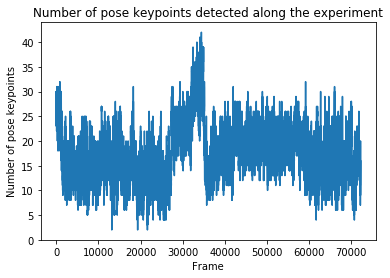

In [12]:
plt.plot(range(total_files), pose_keypoints_time)
plt.xlabel("Frame")
plt.ylabel("Number of pose keypoints")
plt.title("Number of pose keypoints detected along the experiment")
plt.show()

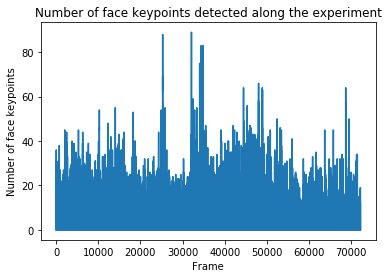

In [13]:
plt.plot(range(total_files), face_keypoints_time)
plt.xlabel("Frame")
plt.ylabel("Number of face keypoints")
plt.title("Number of face keypoints detected along the experiment")
plt.show()

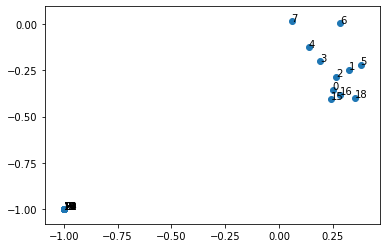

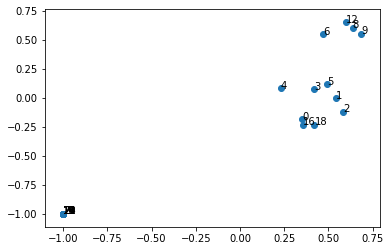

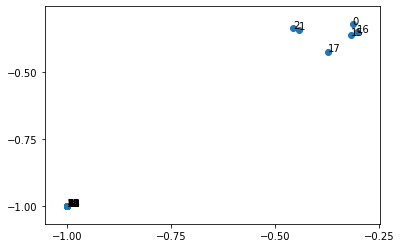

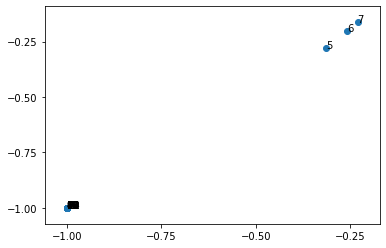

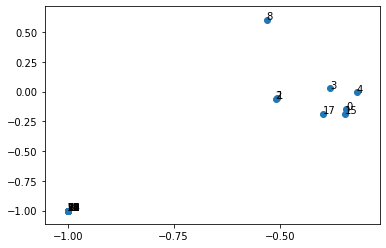

In [47]:
for i in range(len(df['pose_keypoints_2d'])):
    fig, ax = plt.subplots()
    plt.xticks(np.arange(-1, 1, 0.25))
    plt.yticks(np.arange(-1, 1, 0.25))
    ndf = ([df['pose_keypoints_2d'][i][x:x+3] for x in range(0, len(df['pose_keypoints_2d'][i]), 3)])
    ndf = pd.DataFrame(ndf, columns=['x', 'y', 'confidence'])
    ax.scatter(ndf['x'], ndf['y'])
    for i, v in ndf.iterrows():
        ax.annotate(i, (ndf['x'][i], ndf['y'][i]))

![Keypoints mapping](../../../images/keypoints_pose_25.png)

## Analysis of certain patterns